<table width="100%">
<tr>
    <td>
        <h1 style="text-align: left; font-size:300%;">
            DrugRepurposing
        </h1>
        <h1 style="text-align: left; font-size:150%;">
            Automated drug repurposing workflow for rare diseases – using Flask, Monarch API, DGIdb API and XGboost
        </h1> 
    </td>
    <td width="33%">
        <div style="text-align: right">
            <b> A GitHub repository by Niccolò Bianchi</b> <br>
            <a href="https://github.com/NCMBianchi/DrugRepurposing">github.com/NCMBianchi/DrugRepurposing</a><br>
            forked from Carmen Reep's and Nuria Queralt Rosinach's works<br>
        </div>
    </td>
</tr>
</table>

This notebook is meant to implement variations of the functions originally stored in the 'Monarch.py' file, in order to solve some of the issues that do not allow the tool to run.

Once a new pipeline is developed, a new version of the 'Monarch.py' file will be implemented. Step by step all other parts of the entire pipeline involving steps in 'DGIdb.py', 'drugsimilarity.py' and so on will be tested here as well.

![](./PIPELINE_images/github_header.png)

## 1. SETUP

The first step just returns the kernel and Python version to be sure about using the appropriate one -while also setting up some basic logging functions.

In [1]:
import sys,os,platform,datetime,logging,builtins,time
python_executable = sys.executable
python_version = platform.python_version()

# timestamp
today = datetime.date.today()
date_str = today.strftime('%Y-%m-%d')
curr_year = int(str(today)[:4])

# directory set-up
base_data_directory = os.path.join(os.getcwd(), 'drugapp', 'data')
today_directory = os.path.join(base_data_directory, date_str)
os.makedirs(today_directory, exist_ok=True)
disease_name_label = None
## just a placeholder: the aim is to replace it after running run_monarch_api()
## on the first seed

# logging configuration
platform_filename = "running_platform.txt"
platform_file_path = os.path.join(today_directory, platform_filename)
log_filename = "logfile.log"
log_file_path = os.path.join(today_directory, log_filename)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # highest level to capture all logs
file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.ERROR)  # only log errors to the console
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
if not logger.handlers:
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

def current_function_name():
    return inspect.currentframe().f_back.f_code.co_name

# 'w' instead of 'a' here to always overwrite when making a new run
with open(platform_file_path, 'w') as file:
    file.write(f"Python kernel: {python_executable}\n")
    file.write(f"Python version: {python_version}\n")
    file.write("\n")

print("Python kernel:", python_executable)
print("Python version:", python_version)

Python kernel: /Users/ncmbianchi/miniconda3/bin/python3.11
Python version: 3.11.9


The **list of packages** along with the version used is stored in the same *.txt* file where kernel location and version of Python written earlier.

In [2]:
# empty set to store the packages that will be imported:
imported_packages = {}
from importlib.metadata import version
from importlib import import_module

def import_and_log(*args):
    """
    Import a package or a component from a package and log it along 
    with its version immediately.
    """
    try:
        # Importing based on the number of arguments:
        # if 1 argument, 'import <arg_1>' (whole package)
        if len(args) == 1:
            package_name = args[0]
            package = import_module(package_name)
            imported_packages[package_name] = package
            setattr(builtins, package_name, package)  # globally available
            msg = f"Package '{package_name}' imported."
        # if 2 arguments, 'from <arg_1> import <arg_2>' (component from a package)
        elif len(args) == 2:
            package_name, component_name = args
            package = import_module(package_name)
            component = getattr(package, component_name)
            imported_packages[f"{package_name}.{component_name}"] = component
            setattr(builtins, component_name, component)  # globally available
            msg = f"Component '{component_name}' from package '{package_name}' imported."
        else:
            raise ValueError("Invalid number of arguments passed to import_and_log().")
        
        print(msg)  # Print import confirmation
        log_imports_and_versions(msg)  # Log the import and its version
        
    except ImportError as e:
        print(f"Failed to import {args}. Error: {e}")
    except AttributeError as e:
        print(f"Component '{args[1]}' not found in package '{args[0]}'. Error: {e}")

def log_imports_and_versions(message):
    """
    Append import messages and version information of the most
    recently imported package to a file.
    """
    with open(platform_file_path, 'a') as file:
        # Write the message about what was just imported
        file.write(f"{message} ")
        
        # Identify the last imported package or component
        if imported_packages:
            full_name = list(imported_packages.keys())[-1]  # Get the last key in the dictionary
            package_name = full_name.split('.')[0]  # Only use the top-level package name for version retrieval
            try:
                pkg_version = version(package_name)
                version_info = f"(version: {pkg_version})"
            except Exception as e:
                version_info = f"(version not found for {package_name}: {e})"
            
            # Write the latest version info to the file and print it
            file.write(f"{version_info}\n\n")
            print(version_info)

In [3]:
import json  # to save .json files returned by the API
import logging  # to check for running variables
import inspect  # to chec for running functions
import shutil  # to properly copy and rename files in run_monarch_mock()
import ast  # for syntax trees in 'DGIdb.py' steps
from unittest.mock import Mock  # to reverse requests.Response()

# only non-core packages are loaded with the 'import_and_log()' function:
import_and_log('pandas')
import_and_log('requests')
import_and_log('networkx')  # for ' Monarch.py' to plot the network
import_and_log('matplotlib')  # for ' Monarch.py' to plot the network
import_and_log('biothings_client','get_client')  # check if still needed (in older version)
import_and_log('tqdm','tqdm')  # check if still needed (in older version)
import_and_log('rdkit','Chem')  # for 'drugsimilarity.py'
import_and_log('rdkit','RDLogger')  # for 'drugsimilarity.py'
import_and_log('rdkit','DataStructs')  # for 'drugsimilarity.py'

# for ease of use, some packages are reloaded with an alias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# these submodules are imported normally as the main versions are already logged,
# and importlib.import_module() doesn't handle well submodules
from rdkit.Chem import AllChem

Package 'pandas' imported.
(version: 2.1.2)
Package 'requests' imported.
(version: 2.31.0)
Package 'networkx' imported.
(version: 3.1)
Package 'matplotlib' imported.
(version: 3.8.0)
Component 'get_client' from package 'biothings_client' imported.
(version: 0.3.1)
Component 'tqdm' from package 'tqdm' imported.
(version: 4.66.2)
Component 'Chem' from package 'rdkit' imported.
(version: 2024.3.1)
Component 'RDLogger' from package 'rdkit' imported.
(version: 2024.3.1)
Component 'DataStructs' from package 'rdkit' imported.
(version: 2024.3.1)


## 2. MONARCH.py

First let's set-up the function used to make API calls.

**Paths are currently set starting outside the drugapp directory, while later when implemented as .py scripts, paths will be adapted a bit.**

In [4]:
def hit_monarch_api(seed = 'MONDO:0007739', rows = 2000):
    """
    Originally part of NQR's "bioknowledgeReviewer" tool.
    
    This function performs API calls to Monarch to retrieve 'OUT' and 'IN' edges from a query node.
    It retrieves entities plus associations via the Monarch Initiative new V3 API (2023 onward).
    
    The original version used the older Biolink API, no longer supported:
    https://api-biolink.monarchinitiative.org/api/association
     
    Moreover:
       - Biolink supported 'OMIM:' URIs, V3 doesn't and 'MONDO:' is used
       - Biolink required 'association/____', V3 requires 'association?____='
       - Biolink supported the ":" character, V3 requires its ASCII version (i.e.%3A)
       
    It hits two endpoints:
       - association?subject= (for 'OUT' edges)
       - association?object= (for 'IN' edges)
    It returns 'OUT' and 'IN' edges.

    :param node: node ID to query (string). Default: 'MONDO:0007739' (=Huntington Disease).
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :return: two API response objects: 'OUT' and 'IN' response objects, in this order.
    """
    
    logging.info(f"NOW RUNNING: {current_function_name()} with seed {seed}.")

    # API address
    biolink = 'https://api-v3.monarchinitiative.org/v3/api/association'  #V3
    seed_new = seed.split(':')
    seed_call = seed_new[0]+'%3A'+seed_new[1]

    # parameters
    parameters = {'fl_excludes_evidence': False, 'rows': rows}

    # OUT edges API call  ('?subject=')
    out_url = f'{biolink}?subject={seed_call}'
    r_out = requests.get(out_url, params=parameters)  # API call
    logging.info(f"Out edges request URL: {out_url} with parameters {parameters}")
    logging.info(f"Out edges response status: {r_out.status_code}")

    # IN edges API call (?object=)
    in_url = f'{biolink}?object={seed_call}'
    r_in = requests.get(in_url, params=parameters)  # API call
    logging.info(f"In edges request URL: {in_url} with parameters {parameters}")
    logging.info(f"In edges response status: {r_in.status_code}")

    # Error Handling for API responses
    if not r_out.ok or not r_in.ok:
        error_message = f"Error fetching data for seed {seed}: OUT status {r_out.status_code}, IN status {r_in.status_code}"
        logging.error(error_message)
        # Handle error appropriately, could raise an exception or return an error code
        raise Exception(error_message)
    
    # (eventually) create disease directory
    r_out_json = r_out.json()
    r_in_json = r_in.json()
    if seed == input_seed[0]:
        if 'items' in r_out_json and r_out_json['items']:   # identify 'name' and 'id'
            disease_name = r_out_json['items'][0]['subject_label']
            disease_id = r_out_json['items'][0]['subject']
        else:
            logging.warning("Warning: 'associations' key not found in response or no associations present.")
            return None, None
        disease_directory = os.path.join(today_directory, f'{disease_name} ({date_str})')
        os.makedirs(disease_directory, exist_ok=True)  # the date is repeated just for archival purposes
        disease_id_file_path = os.path.join(disease_directory, 'disease_id.txt')
        with open(disease_id_file_path, "w") as text_file:
            
            # store 'disease_name' and 'disease_id'
            text_file.write(f"{disease_id};{disease_name}\n")
            
            # store the list of subject closure for the input_seed
            # (information on the ontology of the disease)
            text_file.write(f"Subject closure:{r_out_json['items'][0]['subject_closure']}")
            logging.info(f"Information on the disease saved to {disease_id_file_path}")
            
    else:
        disease_id = disease_id_label
        disease_name = disease_name_label
        disease_directory = os.path.join(today_directory, f'{disease_name} ({date_str})')
    monarch_directory = os.path.join(disease_directory, 'monarch')
    seed_new = seed.split(':')
    seed_dir = seed_new[0]+'_'+seed_new[1]
    seed_directory = os.path.join(monarch_directory, seed_dir)
    os.makedirs(seed_directory, exist_ok=True)
    
    # store OUT .json file
    out_file_path = os.path.join(seed_directory, f'{seed_dir}_api_response_OUT.json')
    if r_out.ok:
        with open(out_file_path, 'w') as json_file:
            json.dump(r_out_json, json_file)
        logging.info(f"API response saved to {out_file_path}")
    else:
        logging.error(f"Failed to fetch OUT edges: {r_out.status_code} - {r_out.reason}")

    # store IN .json file
    in_file_path = os.path.join(seed_directory, f'{seed_dir}_api_response_IN.json')
    if r_in.ok:
        with open(in_file_path, 'w') as json_file:
            json.dump(r_in_json, json_file)
        logging.info(f"API response saved to {in_file_path}")
    else:
        logging.error(f"Failed to fetch IN edges: {r_in.status_code} - {r_in.reason}")
    
    return r_out, r_in, disease_id, disease_name

In [ ]:
input_seed = ['MONDO:0007739']
r_out, r_in, disease_id_label, disease_name_label = hit_monarch_api()

The test-run above uses a hardcoded variable for 'MONDO:0007739' URI identifier for Huntington's disease –but let's assume that in the actual pipeline it uses variable ```input``` provided by the flaskApp.

**Status response '200' means that the http-request went fine.**

Files are stored according to this tree like structure:

![](./PIPELINE_images/json_tree.png)

In [ ]:
r_out, r_in, disease_id_label, disease_name_label = hit_monarch_api('HGNC:4851')

The run above is just to test that any subsequent run of ```hit_monarch_api()``` doesn't create new subdirectories -if in the same pipeline- while instead storing .json files within the same **.../YYYY-MM-DD/disease YYYY-MM-DD/monarch** directory.

Variables ```disease_id_label``` and ```disease_name_label``` are always returned in order to store as global variables information required for path buildings in some of the functions.

Objects ```r_out``` and ```r_in``` that are returned contain the .json output as a single string.

In [ ]:
print(f"print(r_out.text):{r_out}")  # only displays the http status code

In [ ]:
print(f"print(r_out.text[:200]):{r_out.text[:500]}")  # displays the first 500 lines in the .json file

Then let's define the function that builds the first layer of neighbours and relations: my intention is to make a new version that can handle both one single seed (as in the first layer) or a list of seeds (as in the second and third layer), while also checking if the call for those given sees has already been run: if not, it runs ```hit_monarch_api()``` again; otherwise it retrieves data from the directory corresponding with that seed ID.

In [5]:
def unique_elements(nonUnique_list):
    """
    Short function that remove duplicate elements.
    If the list contains nodes, it will simply convert it into a set{}.
    If the list contains edges, it will remove also edges where subject and object
    are inverted, therefore not being recognised as the same by Python.

    :param nonUnique_list: biomedical entities list, where each entity is either a
    node or an edge in association networks
    :return: list of the same biomedical entities without duplicates
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed list {nonUnique_list[:2]}.")
    logging.info(f"Initial list size: {len(nonUnique_list)}")
    
    # if nonUnique_list is empty
    if not nonUnique_list:
        return []
    
    if isinstance(nonUnique_list[0], dict):
        # Handle list of nodes
        nodes_set = set(tuple(sorted(node.items())) for node in nonUnique_list)
        unique_list = [dict(node) for node in nodes_set]

    elif len(nonUnique_list[0]) == 4 and isinstance(nonUnique_list[0], list):
        # Handle list of edges
        unique_list = []
        seen_edges = set()
        for edge in nonUnique_list:
            subj_id = edge[0]['id']
            obj_id = edge[2]['id']
            norm_edge = tuple(sorted([subj_id, obj_id]))
            if norm_edge not in seen_edges:

                # locally store the simplified/normalised edge for parsing
                seen_edges.add(norm_edge)

                # return the actual full edge
                unique_list.append(edge)
                
    else:
        raise ValueError("Input is not recognised.")

    logging.info(f"Final list size: {len(unique_list)} ({len(nonUnique_list)-len(unique_list)} removed)")
    
    return unique_list


def json_reverse(json_dict):
    """
    Short function that converts calls turned into JSON files by the json() function
    into a request.Response object

    :param seed_list: JSON response stored as a dictionary
    :return: Mock object mimicking requests.Response with the provided JSON data.
    """
    
    json_file = Mock()
    json_file.json.return_value = json_dict
    json_file.status_code = 200
    json_file.ok = True

    return json_file


def get_neighbours(seed_list,layer):
    """
    Originally part of NQR's "bioknowledgeReviewer" tool.
    
    This function parses through the .json files obtained from the hit_monarch_api()
    function, in order to obtain nodes that are related to any seed provided.
    
    If the API call for a given seed has already been run –and therefore a directory
    named with the same URI is present in
    ~/drugapp/data/YYYY-MM-DD/disease YYYY-MM-DD/monarch– then relevant information
    are fetched from the already locally stored 'URI_api_response_OUT.json' and
    'URI_api_response_IN.json' files. This allows for a reduced overhead.

    Information regarding subject, relation and object for both the 'OUT' and 'IN' calls
    are then stored in a table with a noSQL approach (?).

    :param seed_list: biomedical entities list, where each entity is a URI
    identifier string such as 'MONDO:0007739' or 'HGNC:4851'
    :return: neighbours list
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed list {seed_list}.")

    # create the object that will store all the associations found while parsing
    # through the .json file ouputs from hit_monarch_api()
    edges_list = list()
    nodes_list = list()
    global disease_name_label
    global disease_id_label

    # iterate through each seed
    for seed in seed_list:
        seed_new = seed.split(':')
        seed_dir = seed_new[0]+'_'+seed_new[1]
        seed_path = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'monarch', seed_dir)
        
        # run API calls (OUT and IN) for the given seed in the 'FOR' loop
        if os.path.exists(seed_path):
            out_json_path = os.path.join(seed_path, f'{seed_dir}_api_response_OUT.json')
            in_json_path = os.path.join(seed_path, f'{seed_dir}_api_response_IN.json')
            with open(out_json_path, 'r') as file:
                r_out_json = json.load(file)
            with open(in_json_path, 'r') as file:
                r_in_json = json.load(file)
            r_out = json_reverse(r_out_json)
            r_in = json_reverse(r_in_json)
            logging.info(f"API call for {seed} already performed. Files fetched from {seed_path}.")
        else:
            r_out, r_in, disease_id_label, disease_name_label = hit_monarch_api(seed)
        
        # .json file handling
        for associations in [r_out.json()['items'], r_in.json()['items']]:
            for association in associations:
                
                # parse through the files and store the associations in edges_list
                subj = {'id': association['subject'], 'label': association['subject_label']}
                rel = {'label': association['predicate']} # relation ID no longer present
                obj = {'id': association['object'], 'label': association['object_label']}
                notes = {'notes': layer}
                ## reference (link to literature) no longer present
                association_elem = [subj, rel, obj, notes]
                edges_list.append(association_elem)

                # extrapolate list of nodes (both subjects and objects) and store it in nodes_list
                nodes_list.append(subj)
                nodes_list.append(obj)

    # filter for only unique nodes and edges
    nodes_list = unique_elements(nodes_list)
    edges_list = unique_elements(edges_list)

    logging.info(f"Sample of nodes (20): {nodes_list[:20]})")
    logging.info(f"Sample of edges (10): {edges_list[:10]})")
    
    # to fill in - and ADD LOG LINES
    return nodes_list, edges_list, disease_id_label, disease_name_label

![](./PIPELINE_images/csv_columns.png)

Above the columns in the original output's from CR's and NQR's codes.

Their original version was structured so that function ```get_neighbours_list()``` (input = seed list; output = list of neighbours) would call function ```get_neighbours()``` (input = seed list; output = set of neighbour nodes, set of neigbour edges) for each of the nodes in the list.

Within that:

1) The ```hit_monarch_api()``` function (input = node seed; output = r_out, r_in) would be run for:
- the disease id if this is the first layer (single seed)
- each of the node seeds in the second and third layer (multiple seeds)

All following steps are part of the same iteration.

2) The resulting ```r_out``` and ```r_in``` (i.e. response objects containing information in the API .json ouput) would then be parsed by ```get_edges_objects()``` (input = r_out, r_in; output = lists of subjects, relations, objects and references) to obtain information required to build edges –as well as links to publications. This step parses through each of the associations returned by the Monarch Initiative API by considering each of the ```items``` elements in both ```r_out.json()``` and ```r_in.json()``` one after the other to then extrapolate information corresponding to certain labels:
   - ```association['subject']``` for the subject id, and ```association['subject_label']``` for its label
   - ```association['predicate']``` for the relation id and label (duplicate)
   - ```association['object']``` for the object id, and ```association['object_label']``` for its label
   - ```association['publications']``` for the link to an annotated publication, if present
<br>
3) The edges are then obtained by running function ```get_edges()``` (input = lists of subjects, relations, objects and reference, and 'id' flag; output = set of list of edges), which iterates through elements in list of subjects –all lists from ```get_edges_objects()``` are the same lenght– to build a set of lists (of dictionaries) that can be summarised as this: **{('Subject1', 'hasPhenotype', 'Object1', 'Ref1'), ('Subject2', 'isOrthologOf', 'Object2', 'Ref2')}**.

After these steps, the original code ran a few data allocation steps:

4) Function ```keep_edges()``` (input = empty set of edges, edges dataframe ; output = set of edges) handles the edges in a Python set{} to only store unique edges and have no duplicates. The resulting set would only contain unique edges by adding edges at each iteration of ```get_neighbours()``` within ```get_neighbours_list()```.
5) Function ```keep_nodes()``` (input = empty set of nodes, edges dataframe, set of seed nodes; output = set of nodes) takes into account the set obtained by the seed list as input for the ```get_neighbours()``` mother function. The result is the same as in keep_edges() a set of unique nodes, where nodes are added at each iteration.

I made a ```unique_element()``` function that takes arguments with either dict-tuples (*i.e.* (id:label)) or lists of three items as elements. Based on the context whether nodes or edges it uses the correct approach –but since it's a very similar operation one function only is enough at this point. The original separate version would anyway be available in older **2024.0.__** commits. This function still makes sense as a standalone as it's very self-contained and would be used again later steps. <br>**{CHECK BASED ON noSQL DB: it might not be necessary}**

This original version contemplated several sub-functions as they would also be used by macro-function ```get_orthopheno_list()``` (input = seed list; ouput = node list) which would also add a ```keep_node_type()``` step (input = edge list, seed list; ouput = __ of orthologs/phenotypes) that filters edges based on object nodes that only correspond to certain relational ontology type (i.e. RO: -either ortholog genes or phenotypes). Such step would be performed twice after each of two rounds of ```get_neighbours()```, once per ontology type. This is meant in order to have only phenotypes in the second layer, and ortholog genes in the third one.  

These were some of the steps that would cause the most issues and prevent the tool from running, as they would filter out all edges for not meeting the identity requirements above. Moreover, they seemed conceptually unnecessary –if not wrong.

![](./PIPELINE_images/flowchart_placeholder.png)

**My version of the code takes another approach**: by allowing it to perform each of the three layer steps we can avoid having too many functions –as they would not be re-used elsewhere.

The overall function is still not overly complicated though thanks to focusing on **'IF' gates** that allow for slight changes in operation.

This also allows to already store all information relevant for the **list of nodes** and **list of edges** that are the final outputs of the entire *Monarch.py* original script: I want to mantain the same data structure to then re-implement the original following steps.

The original code also contempletated a **get_connections(nodes)** step that would fetch by subsequent (redundant) calls information on the nodes in the list. At some point a ```filter_edges()``` (input = list of nodes, list of edges; output = list of filtered edges) function, to only keep edges where both subject and object node are part of the node list outputed by each.

This step seemed unnecessary to me, so I skipped it.

Below a test run of the ```get_neibours()``` function:

In [ ]:
input_seed = ['MONDO:0007739']  # required as a list
firstLayer_nodes, firstLayer_edges, disease_id_label, disease_name_label = get_neighbours(input_seed)

Below a test to see how many elements are returned from the first run. Apparently both would return 32 elements, which is weird as I would expected ```nodes-1``` edges, as one of the nodes would be the initial input seed 'MONDO:0007739'.

In [ ]:
print(len(firstLayer_nodes))

In [ ]:
print(firstLayer_nodes)

In [ ]:
any(item['id'] == 'MONDO:0007739' for item in firstLayer_nodes)

In [ ]:
print(len(firstLayer_edges))

In [ ]:
print(firstLayer_edges)

In [ ]:
edges_without_mondo = [edge for edge in firstLayer_edges if not (edge[0].get('id', '') == 'MONDO:0007739' or edge[2].get('id', '') == 'MONDO:0007739')]
edges_without_mondo

Turns out that the extra edge comes from I guess the API considers as an 'alias' of 'MONDO:0007739': **'MONDO:0016621'**, which is the juvenile version of HD.

I will not add a step that filters this edge out as:
1) this edge is still relevant
2) I assume the API would never return edges that are not meaningful
   

In [ ]:
edges_with_mondo_both = [edge for edge in firstLayer_edges if edge[0].get('id', '') == 'MONDO:0007739' and edge[2].get('id', '') == 'MONDO:0007739']
edges_with_mondo_both

Below instead the final function for the ***Monarch.py*** step: this function summaries both ```run_monarch()``` and ```run_monarch_symptoms()``` functions from CR's original code: her flaskApp meant to ask to the user for the selection of one symptom only on which to build the network. I tried bypassing that and checking how much longer it would take to check for ALL symptoms (*i.e.* first layer of phenotypes).

In [6]:
def run_monarch(input_id = 'MONDO:0007739'):
    """
    This function runs the whole Monarch script and saves nodes and edges files.

    :param input_number: The input MONDO: URI  of the disease
    :return: nodes and edges files in /monarch folder
    """
    
    logging.info(f"NOW RUNNING: {current_function_name()} with seed {input_id}.")

    start_time = time.time()
    
    # First layer: use the flaskApp input
    firstLayer_nodes, firstLayer_edges, disease_id_label, disease_name_label = get_neighbours(input_id,'first_layer')

    # Second layer: use the nodes in the first layer
    firstLayer_seeds = [item['id'] for item in firstLayer_nodes]  # turn into a list of IDs
    firstLayer_seeds = [fl_id for fl_id in firstLayer_seeds if fl_id not in input_id]  # to avoid re-running nodes and counting them in the second layer
    secondLayer_nodes, secondLayer_edges, disease_id_label, disease_name_label = get_neighbours(firstLayer_seeds,'second_layer')

    # Third layer: use the nodes in the second layer
    secondLayer_seeds = [item['id'] for item in secondLayer_nodes]  # turn into a list of IDs
    secondLayer_seeds = [sl_id for sl_id in secondLayer_seeds if sl_id not in firstLayer_seeds]  # to avoid re-running nodes and counting them in the third layer
    thirdLayer_nodes, thirdLayer_edges, disease_id_label, disease_name_label = get_neighbours(secondLayer_seeds,'third_layer')
    
    # MERGE the nodes' lists
    nonUnique_nodes = firstLayer_nodes + secondLayer_nodes + thirdLayer_nodes
    unique_nodes = unique_elements(nonUnique_nodes)
    
    # MERGE the edges' lists
    nonUnique_edges = firstLayer_edges + secondLayer_edges + thirdLayer_edges
    unique_edges = unique_elements(nonUnique_edges)
    
    # save the unique nodes and edges as CSV
    monarch_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'monarch')
    nodes_df = pd.DataFrame(unique_nodes)
    nodes_df.to_csv(os.path.join(monarch_directory, f'{disease_name_label}_{date_str}_monarch_nodes.csv'), index=False)
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(monarch_directory, f'{disease_name_label}_{date_str}_monarch_edges.csv'), index=False)

    logging.info("CSV files saved in Monarch directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"Run finished in {minutes} minutes and {seconds} seconds")  # Print duration in minutes and seconds

    return unique_nodes, unique_edges, disease_id_label, disease_name_label

In [7]:
input_seed = ['MONDO:0007739']  # required as a list
nodes, edges, disease_name_id, disease_name_label = run_monarch(input_seed)

Run finished in 0 minutes and 2 seconds


**I ran the code above**: it made 594 unique calls (65MB dowloaded in 18min with a not-so-great connection): all duplicate calls were skipped. Below the number of edges and nodes in the 3-layered network for Huntington Disease.

In [8]:
len(edges)

12726

In [9]:
len(nodes)

7375

My next steps are:
- **checking which of the node types might be un-necessary for this purpose** so that they can be ignored ahead of making API calls, to save time
- attempting a data-visualisation line to show the network clusters (at least for the purpose of my thesis)

In [ ]:
print(nodes[:20])

In [10]:
unique_URItype = set()
for node in nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0] 
        unique_URItype.add(URI)
print(unique_URItype)

{'Reactome', 'HP', 'SGD', 'Xenbase', 'HGNC', 'GO', 'FB', 'CL', 'SO', 'NCBITaxon', 'MP', 'WB', 'PomBase', 'OBA', 'CHEBI', 'PATO', 'ZFIN', 'PR', 'CHR', 'MGI', 'ECTO', 'RGD', 'dictyBase', 'NCBIGene', 'UPHENO', 'MONDO', 'UBERON'}


Above all the URI types found within these three layers:
- NCBItaxon: Taxonomic data from the NCBI Taxonomy database, used for species
- FB: FlyBase identifier for Drosophila genes and genetic information
- MGI: Mouse Genome Informatics for mouse genetic information
- Xenbase: Xenopus biology database for African clawed frog genetic and developmental data
- **MP**: Mammalian Phenotype Ontology, describing phenotypic abnormalities in mammals
- **CL**: Cell Ontology, used for cell type definitions
- SGD: Saccharomyces Genome Database for yeast genetics and biology
- ZFIN: Zebrafish Information Network for zebrafish genetic and developmental information
- dictyBase: Resource for Dictyostelid species genetics and cell biology
- **CHEBI**: Chemical Entities of Biological Interest, a database of molecular entities focused on 'small' chemical compounds
- PomBase: Resource for genetic information on the fission yeast Schizosaccharomyces pombe
- ECTO: Exposure Ontology, describing types of exposure to environmental entities
- **CHR**: Chromosome Ontology, for specifying chromosome parts and structures
- PATO: Phenotypic Quality Ontology, describing how phenotypes are qualitatively altered
- **NCBIgene**: Gene identifiers from the NCBI gene database
- WB: WormBase, providing genetic and biological data for Caenorhabditis elegans and related nematodes
- **SO**: Sequence Ontology, which provides a set of terms and relationships used to describe the features and attributes of biological sequence
- **GO**: Gene Ontology, provides a controlled vocabulary to describe gene and gene product attributes in any organism
- **OBA**: Ontology for Biomedical Associations, used to specify associations in biomedical contexts
- **UPHENO**: Unified Phenotype Ontology, integrating multiple phenotype ontologies across different species
- RGD: Rat Genome Database, provides genetic and phenotypic data for Rattus norvegicus
- **HP**: Human Phenotype Ontology, describing phenotypic abnormalities found in human disease
- **HGNC**: HUGO Gene Nomenclature Committee, providing a unique identifier for human genes
- PR: Protein Ontology, provides structured classification of proteins and their relationships
- UBERON: Multi-species anatomy ontology, covering anatomical structures in multiple animal species
- **MONDO**: Monarch Disease Ontology, integrates multiple sources of disease data to provide unified disease definitions
- **Reactome**: A database of reactions, pathways, and biological processes

In **bold** those I deem relevant candidates, although probably only ```HGNC:``` and ```HP:``` should be considered respectively for genes and phenotypes. 

In [11]:
URI_counts = {}
for node in nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0]
        if URI in URI_counts:
            URI_counts[URI] += 1
        else:
            URI_counts[URI] = 1
print(URI_counts)

{'MONDO': 1332, 'HGNC': 3020, 'HP': 1342, 'CHEBI': 578, 'Reactome': 102, 'MGI': 117, 'NCBIGene': 118, 'RGD': 46, 'GO': 323, 'UBERON': 107, 'WB': 64, 'UPHENO': 66, 'ZFIN': 42, 'FB': 47, 'NCBITaxon': 9, 'PATO': 6, 'CL': 12, 'PR': 4, 'PomBase': 5, 'Xenbase': 14, 'CHR': 2, 'dictyBase': 7, 'SGD': 3, 'MP': 4, 'ECTO': 3, 'SO': 1, 'OBA': 1}


In comparison CR's output for nodes has this URI distribution:

In [12]:
URI_counts = {}
CR_df = pd.read_csv('./drugapp/data/reference/Huntington disease (2022-06-27)/monarch/monarch_nodes_disease_v2022-06-27.csv')
if 'id' in CR_df.columns:
    CR_nodes = CR_df['id'].tolist()
for node in CR_nodes:
    URI = node.split(':')[0]
    if URI in URI_counts:
        URI_counts[URI] += 1
    else:
        URI_counts[URI] = 1
print(URI_counts)

{'MGI': 84, 'MONDO': 2, 'HGNC': 17, 'HP': 68, 'dbSNPIndividual': 9, 'ClinVarVariant': 3, 'REACT': 1, 'dbSNP': 22, 'ENSEMBL': 4, 'WormBase': 2, 'ZFIN': 4, 'FlyBase': 2}


The current version of the code will keep all nodes currently found, although changes in the code by accessing other tools in the API (*e.g.* ```v3/api/entity/{id}/{category}``` to only find associations to a given seed –both IN and OUT– that correspond to a certain category, such as 'phenotype') and **filtering only for certain categories** –and not just certain URIs– **at each layer**.

This could be done by implementing a whitelist of accepted URIs –or a blacklist of discarded ones. So far we will keep all of them to have the widest array of information of possible. In the end the information we require are in nodes with URI ```MONDO:```, ```HGNC:``` and ```HP:```, but by having also other URIs when building the three layer we can reach certain genes and phenotypes that would always not directly associate.

Below a visual representation of the network (takes about 2min):

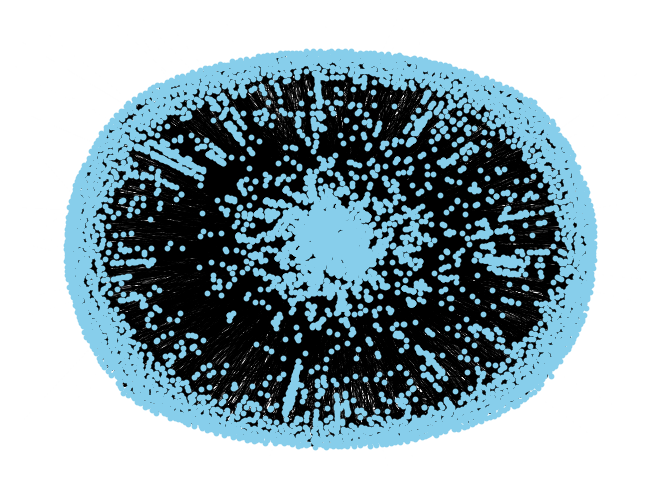

In [13]:
logging.getLogger().setLevel(logging.WARNING)  # logging SILENCED

G = nx.DiGraph()
for edge in edges:
    subj_id = edge[0]['id']
    obj_id = edge[2]['id']
    rel_label = edge[1]['label']
    G.add_edge(subj_id, obj_id, label=rel_label)

pos = nx.spring_layout(G)
labels = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_color='skyblue',
        node_size=10, edge_color='k', width=0.5)
plt.show()

logging.getLogger().setLevel(logging.DEBUG)

## 3. DGIdb.py

This section **matches genes** in the nodes obtained from the previous steps **to drugs** via the DGIdb (*i.e* Drug-gene interaction database).

CR's original version would load the dataframe for the edges from the .csv files created in the previous step based on the current date alone –I instead changed the main ```run_dgidb()``` (input = date; output = lists of nodes and edges matched with drugs) function so that it takes both input seed and date to determine which folder to access.

The nodes list is then parsed through the ```get_genes()``` (input = full nodes list; output = gene-only nodes list) function that retrieves the list of genes only –based on the condition for URIs to contain 'HGNC:' and few other ontologies. Then the list of gene-only node is matched against the ENTREZ database (*i.e.* ```normlize_genes_to_graph()``` (input = gene-only node list; output = same list with ENTREZ ids)) to use that as a seed for DGIdb via ```hit_dgidb_api()``` (input = gene-id list; output = gene-to-drug edges list).

![](./PIPELINE_images/dgidb.png)

Finally the resulting list of edges with information from both Monarch and DGIdb APIs would be converted in a dictionary, stored as an intermediate to then make new calls to add metadata –a step which I completely skipped again as many errors would arise and such information are not necessary at this point. 

My approach focuses instead on first building the **```hit_dgidb_api()```** to make calls for one node at a time –node that belongs to category ```gene```. Therefore it would return the corresponding association edges for drugs related to that given gene.

In [14]:
def get_entrez(nonENTREZ_seed):
    """
    This function performs API calls to DGIdb to retrieve OUT and IN edges
    from a query node (i.e. gene).

    :param ENTREZ_seed: single ENTREZ ID for a gene.
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :return: an api response objects.
    """

    mg = get_client('gene')

    qterm_label = nonENTREZ_seed.split(':')[1]
    namespace = nonENTREZ_seed.split(':')[0].lower()
    scopes_label = []
    
    if 'flybase' == namespace:
        scopes_label = ['flybase']
    elif 'wormbase' == namespace:
        scopes_label = ['wormbase']
    elif 'mgi' == namespace:
        qterm_label = 'MGI:' + qterm_label  # prefix required for 'MGI' IDs
        scopes_label = ['mgi']
    elif 'hgnc' == namespace:
        scopes_label = ['hgnc']
    elif 'ensembl' == namespace:
        scopes_label = ['ensembl.gene']
    elif 'zfin' == namespace:
        scopes_label = ['zfin']
    else:
        logging.info("Unsupported namespace for gene ID conversion.")
        return None
        
    try:
        ENTREZ_seed = mg.querymany(qterms = qterm_label,
                                       scopes = scopes_label,
                                       fields = 'entrezgene',
                                       size = 1)
        if ENTREZ_seed:
            return ENTREZ_seed[0]['entrezgene'] if 'entrezgene' in ENTREZ_seed[0] else None
    except Exception as e:
        logging.error(f"API call failed for {qterm_label} with error: {e}")
    
    return None


def hit_dgidb_api(ENTREZ_seed, rows = 2000):
    """
    This function performs API calls to DGIdb to retrieve OUT and IN edges
    from a query node (i.e. gene).

    :param ENTREZ_seed: single ENTREZ ID for a gene.
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :return: an api response objects.
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed {ENTREZ_seed})'.")

    # load strings required for path location
    global disease_name_label
    global disease_id_label
    
    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})','dgidb')
    if not os.path.isdir(dgidb_directory):
        os.makedirs(dgidb_directory)
    
    # API address and parameters
    dgibd_link = 'https://dgidb.org/api/v2/interactions.json?'
    parameters = {'fl_excludes_evidence': False, 'rows': rows}
    
    # API call
    r_drugs = requests.get(f'{dgibd_link}{ENTREZ_seed}',params=parameters)
    logging.info(f"Drug request URL: {dgibd_link} with parameters {parameters}")
    logging.info(f"In edges response status: {r_drugs.status_code}")

    # Error Handling for API responses
    if not r_drugs.ok:
        error_message = f"Error fetching data for seed {ENTREZ_seed}: status {r_drugs.status_code}"
        logging.error(error_message)
        # Handle error appropriately, could raise an exception or return an error code
        raise Exception(error_message)

    # store DRUGS .json file
    ENTREZ_new = ENTREZ_seed.split('=')
    ENTREZ_dir = ENTREZ_new[0]+'_'+ENTREZ_new[1]
    drug_seed_directory = os.path.join(dgidb_directory, ENTREZ_dir)
    os.makedirs(drug_seed_directory, exist_ok=True)
    drugs_file_path = os.path.join(drug_seed_directory, f'{ENTREZ_dir}_api_response.json')
    if r_drugs.ok:
        with open(drugs_file_path, 'w') as json_file:
            json.dump(r_drugs.json(), json_file)
        logging.info(f"API response saved to {drugs_file_path}")
    else:
        logging.error(f"Failed to fetch IN edges: {r_drugs.status_code} - {r_drugs.reason}")

    return r_drugs

Below a test-call for the DGIdb API:

In [ ]:
r_drugs = hit_dgidb_api('genes=HTT')

And below a test-call for the ENTREZ conversion both via the appropriate ```get_entrez()``` function and directly:

In [15]:
node = {'id':'HGNC:18212','label':'HPCAL4'}
nonENTREZ_seed = node['id']
ENTREZ_seed = get_entrez(nonENTREZ_seed)
print(f"ENTREZ id: {ENTREZ_seed}")

ENTREZ id: 51440


In [16]:
print(get_client('gene').querymany(qterms = '18212',
                                       scopes = 'hgnc',
                                       fields = 'entrezgene',
                                       size = 1))

[{'query': '18212', '_id': '51440', '_score': 16.270744, 'entrezgene': '51440'}]


Then I developed a wrapper function **```run_dgidb()```** that based on both ```input_seed``` from the rest of the pipeline and date (object ```today``` set at the beginning) retrieves the appropriate nodes and edges list files –although here in this notebook that section will be commented out as such variables are already present in the global workspace– to then iterate through the nodes in the node list file to get all the edges between genes and drugs –after filtering within the function to extrapolate the appropriate subset of gene-only nodes, and calling for subfunction ```get_entrez()``` to retrieve the equivalent 'ENTREZ' id, each node is parsed through ```hit_dgidb_api()```.

The resulting edges are appended to the existing ```edges``` object, while the ```nodes``` object is overwritten by listing all nodes in the resulting edges list: only unique edges and nodes are kept –by using the same ```get_unique()``` function from the 'Monarch.py' section.

This approach allows for a more straightforward pipeline.

In [35]:
def run_dgidb(monarch_input,date):
    """
    This function runs the whole DGIdb script and saves nodes and edges files.
    :param date: the input seed from the run_monarch() step and the date of
    creation of the disease graph
    :return: nodes and edges files in /DGIdb folder
    """

    start_time = time.time()
    
    logging.info(f"NOW RUNNING: {current_function_name()} following 'run_monarch({monarch_input})'.")

    global nodes
    global edges

    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'dgidb')
    
    # initialise gene-to-drug list
    drug_edges = []

    for node in nodes:
        ENTREZ_id = get_entrez(node['id'])
        if ENTREZ_id:
            entrez_dir = os.path.join(dgidb_directory, f'genes_{ENTREZ_id}')
            if os.path.exists(entrez_dir):
                # Assuming there's a specific file you read from
                with open(os.path.join(entrez_dir, f'genes_{ENTREZ_id}_api_response.json'), 'r') as file:
                    drug_data = json.load(file)
                logging.info(f"Data for ENTREZ ID: {ENTREZ_id} fetched from local storage.")
            else:
                try:
                    r_drugs = hit_dgidb_api(f'genes={ENTREZ_id}')
                    if r_drugs.ok:
                        drug_data = r_drugs.json()
                        if drug_data:
                            # Save this response locally for future use
                            if not os.path.exists(entrez_dir):
                                os.makedirs(entrez_dir)
                            with open(os.path.join(entrez_dir, f'genes_{ENTREZ_id}_api_response.json'), 'w') as file:
                                json.dump(drug_data, file)
                            for key in ['ambiguousTerms', 'matchedTerms', 'unmatchedTerms']:
                                terms = drug_data.get(key, [])
                                for term in terms:
                                    interactions = term.get('interactions', [])
                                    for interaction in interactions:
                                        drug_node = {'id': interaction['drugConceptId'], 'label': interaction['drugName']}
                                        relation = {'label': 'dgidb:interacts_with'}
                                        notes = {'notes': key}
                                        drug_edges.append((node, relation, drug_node, notes))
                        else:
                            logging.info(f"No drug data returned for ENTREZ ID: {ENTREZ_id}")
                except Exception as e:
                    logging.error(f"Failed to process drug interactions for {node['id']}: {str(e)}")

    # MERGE new edges with the existing ones
    all_edges = edges + drug_edges
    unique_edges = unique_elements(all_edges)  # they should already be unique

    # EXTRACT nodes from edges
    all_nodes = [edge[0] for edge in unique_edges] + [edge[2] for edge in unique_edges]
    unique_nodes = unique_elements(all_nodes)

    # save the unique nodes and edges as CSV
    nodes_df = pd.DataFrame(unique_nodes)
    nodes_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_nodes.csv'), index=False)
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_edges.csv'), index=False)

    logging.info("CSV files saved in DGIdb directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"Run finished in {minutes} minutes and {seconds} seconds")  # Print duration in minutes and seconds
    
    return unique_nodes, unique_edges

Within the pipeline object names are re-used to avoid overhead, but each step is meticulously stored in .csv files so that each step can be thoroughly analysed.

In [31]:
nodes, edges = run_dgidb(input_seed,today)

2024-05-03 15:00:31,289 - root - ERROR - Failed to process drug interactions for MGI:1926089: 'str' object has no attribute 'get'
2024-05-03 15:01:53,400 - root - ERROR - Failed to process drug interactions for HGNC:644: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2024-05-03 15:12:16,704 - root - ERROR - Failed to process drug interactions for MGI:95757: 'str' object has no attribute 'get'
2024-05-03 15:45:34,506 - root - ERROR - Failed to process drug interactions for HGNC:2637: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2024-05-03 16:02:52,212 - root - ERROR - Failed to process drug interactions for MGI:1914497: 'str' object has no attribute 'get'
2024-05-03 16:09:03,018 - root - ERROR - Failed to process drug interactions for MGI:107678: 'str' object has no attribute 'get'
2024-05-03 16:10:10,119 - root - ERROR - Failed to process drug interactions for MGI:1277959: 'str' object has no 

Run finished in 117 minutes and 42 seconds


In [32]:
len(edges)

16576

In [33]:
len(nodes)

9975

In [34]:
URI_counts = {}
for node in nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0]
        if URI in URI_counts:
            URI_counts[URI] += 1
        else:
            URI_counts[URI] = 1
print(URI_counts)

{'MONDO': 1332, 'HGNC': 3020, 'HP': 1342, 'CHEBI': 578, 'chembl': 2582, 'Reactome': 102, 'MGI': 117, 'NCBIGene': 118, 'RGD': 46, 'GO': 323, 'UBERON': 107, 'WB': 64, 'UPHENO': 66, 'ZFIN': 42, 'FB': 47, 'wikidata': 18, 'NCBITaxon': 9, 'PATO': 6, 'CL': 12, 'PR': 4, 'PomBase': 5, 'Xenbase': 14, 'CHR': 2, 'dictyBase': 7, 'SGD': 3, 'MP': 4, 'ECTO': 3, 'SO': 1, 'OBA': 1}
